# Tabulated Weak Rate Example

Here we walk through an example of a single network consisting of just 2 nuclei linked together by electron-capture and beta-decay.

We'll consider ${}^{56}\mathrm{Ni}$ and ${}^{56}\mathrm{Co}$.  The evolution of this system is:

$$\frac{dY_\mathrm{Ni}}{dt} = -\lambda_\mathrm{e-cap} Y_\mathrm{Ni} + \lambda_\mathrm{\beta} Y_\mathrm{Co}$$

$$\frac{dY_\mathrm{Co}}{dt} = +\lambda_\mathrm{e-cap} Y_\mathrm{Ni} - \lambda_\mathrm{\beta} Y_\mathrm{Co}$$

where $Y_\mathrm{Ni}$ and $Y_\mathrm{Co}$ are the molar fractions of the nuclei.

Let's create a network with these rates.

pynucastro will use the tabulated rates from {cite:t}`langanke:2001`.

In [1]:
import pynucastro as pyna

We access the tabular rates from {py:obj}`TabularLibrary <pynucastro.rates.library.TabularLibrary>`.  Alternately, for this example, we could directly use {py:obj}`LangankeLibrary <pynucastro.rates.library.LangankeLibrary>`.

In [2]:
tl = pyna.TabularLibrary()
lib = tl.linking_nuclei(["ni56", "co56"])
lib

Ni56 + e⁻ ⟶ Co56 + 𝜈           [Q =   2.13 MeV] (Ni56 --> Co56 <weaktab_langanke>)
Co56 ⟶ Ni56 + e⁻ + 𝜈           [Q =  -2.13 MeV] (Co56 --> Ni56 <weaktab_langanke>)

We'll create a {py:obj}`RateCollection <pynucastro.networks.rate_collection.RateCollection>` so we can evaluate the rates easily

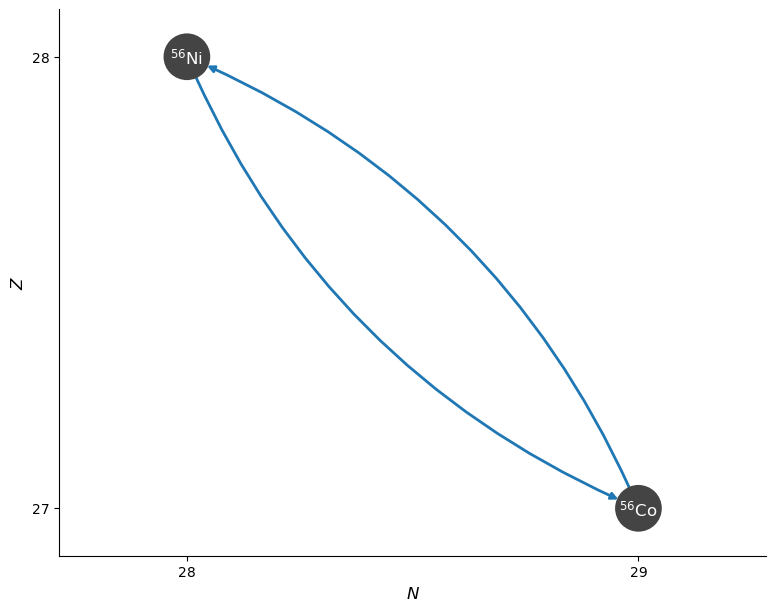

In [3]:
rc = pyna.RateCollection(libraries=[lib])
fig = rc.plot(curved_edges=True)

Let's create a {py:obj}`Composition <pynucastro.networks.rate_collection.Composition>`---we'll make equal amounts of Ni and Co

In [4]:
comp = pyna.Composition(rc.unique_nuclei)
comp.set_equal()

We can see from the electron fraction that we are a little neutron-rich

In [5]:
Ye = comp.ye
Ye

0.4910714285714286

Now let's compute the rates.  We'll pick a density (actually $\rho Y_e$) and temperature
right on one of the points tabulated in the original source so we can directly compare
to what is in the table.

In [6]:
rho = 1.e7 / Ye
T = 1.e9

The rates are proportional to the molar fractions, so we can get those too (via {py:func}`get_molar <pynucastro.networks.rate_collection.Composition.get_molar>`):

In [7]:
Y = comp.get_molar()
Y

{Co56: 0.008928571428571428, Ni56: 0.008928571428571428}

Now we can evaluate the rates using {py:func}`evaluate_rates <pynucastro.networks.rate_collection.RateCollection.evaluate_rates>`:

In [8]:
rc.evaluate_rates(rho, T, comp)

{Co56 ⟶ Ni56 + e⁻ + 𝜈: 2.6914293082016787e-23,
 Ni56 + e⁻ ⟶ Co56 + 𝜈: 7.240723730837853e-06}

We can also compute $dY/dt$ for the network via {py:func}`evaluate_ydots <pynucastro.networks.rate_collection.RateCollection.evaluate_ydots>`:

In [9]:
ydots = rc.evaluate_ydots(rho, T, comp)
ydots

{Co56: 7.240723730837853e-06, Ni56: -7.240723730837853e-06}

If we look at the original tables from {cite:t}`langanke:2001`, they tabulate (for the conditions we selected above):

```
 neg. daughter Ni56 z=28 n=28 a=56 Q= -1.6240                                           
 pos. daughter Co56 z=27 n=29 a=56 Q=  1.6240                                           
                      +++ Ni56 --> Co56 +++      --- Co56 --> Ni56 ---
   t9   lrho    uf    lbeta+    leps-    lrnu    lbeta-    leps+  lrnubar
...
  1.00  7.0   0.689  -15.299   -3.091   -3.097  -20.521  -23.856  -20.878
...
```

We see that there are 2 rates for ${}^{56}\mathrm{Ni} \rightarrow {}^{56}\mathrm{Co}$: positron decay (`lbeta+`) and electron capture (`leps-`), and 2 rates for ${}^{56}\mathrm{Co} \rightarrow {}^{56}\mathrm{Ni}$: beta-decay (`lbeta-`) and positron capture (`leps+`).  All of these are log base-10 in $\mathrm{s}^{-1}$.

In this case, the dominant rate is the electron capture.  Let's compute that rate manually

In [10]:
lambda_ec = 10.0**-3.091
r = Y[pyna.Nucleus("ni56")] * lambda_ec
r

7.240723730837861e-06

We get the same result as `evaluate_rates()`!

Finally, we can compute the evolution of the electron fraction:
    
$$Y_e = \sum_k Z_k Y_k \ \rightarrow \ \frac{dY_e}{dt} = \sum_k Z_k \frac{dY_k}{dt}$$

In [11]:
dyedt = sum(q.Z * ydots[q] for q in rc.unique_nuclei)
dyedt

-7.240723730837865e-06